Apply proposed model to the migration simulation. <br>
Model is from 04 Decoder Transformer.

In [ ]:
# connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Import libraries

In [ ]:
import math
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Process, Queue
import numpy as np
import pandas as pd
import sklearn.preprocessing as skp
import time
import torch
import torch.nn as nn
from torch.nn import functional as F
from imblearn.over_sampling import SMOTENC
import threading

# Hyperparameters

In [ ]:
# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 4 # what is the maximum context length for predictions?
max_iters = 2000
eval_interval = 10 # previously, use 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 50 # previously, use 200
n_embd = 64
n_head = 8
n_layer = 8
dropout = 0.2
# ------------
random_state = 2023
torch.manual_seed(random_state)
np.random.seed(random_state)
debug = False
model_path = '/content/gdrive/MyDrive/lab/Transformer/MGM5.pt'

# Util Functions

In [ ]:
def binning(df, column, bin_edges, labels=None):
    """
    Function that performs binning for a numeric column in a Pandas dataframe.
    df: Pandas dataframe
    column: name of the numeric column to be binned
    bin_edges: list of bin edges to use
    labels: list of labels to assign to the bins
    """
    # Use the Pandas cut function to bin the column
    df[column + '_binned'] = pd.cut(df[column], bins=bin_edges, labels=labels)
    
    return df

In [ ]:
def compare_attributes(df1, df2, columns_to_plot=None, legend_labels=None):
    if columns_to_plot is None:
        columns_to_plot = df1.columns
    
    # Iterate over each column in the dataframes
    for i, col in enumerate(columns_to_plot):
        # Create a new figure and axis object for each attribute
        fig, ax = plt.subplots()

        # Get the frequencies for each unique value in the column
        freq1 = df1[col].value_counts()
        freq2 = df2[col].value_counts()

        # Combine the frequencies into a single dataframe
        freq_df = pd.concat([freq1, freq2], axis=1, keys=['df1', 'df2'])

        # Plot the frequencies as a bar chart
        freq_df.plot(kind='bar', ax=ax, rot=0)

        # Set the title for the subplot
        ax.set_title(col)

        # Add a legend to the plot
        plt.legend(legend_labels)

        # Show the plot
        plt.show()


In [ ]:
def count_unique_elements(my_list):
    # Create an empty list to store unique elements
    unique_list = []
    
    # Loop through each element in the list
    for element in my_list:
        # Check if the element is not already in the unique list
        if element not in unique_list:
            # If it's not, add it to the unique list
            unique_list.append(element)
            unique_list.sort()
            max_vocab = max(unique_list)
    
    # Return the length of the unique list and the unique list itself
    return len(unique_list), unique_list, max_vocab

In [ ]:
# Convert the model output into a pandas dataframe
def create_dataframe(data_list, num_columns, header=None):
    # Calculate the number of rows needed based on the length of the data_list
    # and the specified number of columns
    num_rows = len(data_list) // num_columns + (len(data_list) % num_columns > 0)
    
    # Create a 2D array with the data_list values
    data_array = [data_list[i:i+num_columns] for i in range(0, len(data_list), num_columns)]
    
    # Add empty values to the end of each row to ensure all rows have the same length
    for i in range(len(data_array)):
        while len(data_array[i]) < num_columns:
            data_array[i].append(None)
    
    # Create a Pandas dataframe from the 2D array
    df = pd.DataFrame(data_array, columns=header)
    
    return df


In [ ]:
def flatten_list(nested_list):
    flat_list = []
    for inner_list in nested_list:
        for element in inner_list:
            flat_list.append(element)

    return flat_list

In [ ]:
## Train and Test Splits
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))

    if debug == True:
        print(f"ix: {ix}")

    x = torch.stack([data[i:i+block_size] for i in ix])

    if debug == True:
        print(f"x: {x}")

    y = torch.stack([data[i+1:i+block_size+1] for i in ix])

    if debug == True:
        print(f"y: {y}")

    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):

            if debug == True:
                print(f"k: {k}")

            X, Y = get_batch(split)

            if debug == True:
                print(f"X: {X}")
                print(f"Y: {Y}")
                
            logits, loss = model(X, Y)

            if debug == True:
                print(f"logits: {logits}")
                print(f"loss: {loss}")

            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
def plot_attribute_distribution(df):
    # check the distribution of each attribute
    # iterate over columns in dataframe
    for col in df.columns:
        # count the frequency of each attribute
        value_counts = df[col].value_counts()
        # create a bar chart of the frequency of each attribute
        plt.figure()
        plt.bar(value_counts.index, value_counts.values)
        plt.title(col)
        plt.show()

In [ ]:
def print_uniq_val(df):
    # Create an empty dictionary to store unique values for each column
    unique_values_dict = {}

    # Iterate through each column of the dataframe
    for column_name in df.columns:
        # Get the unique values of the current column
        unique_values = df[column_name].unique().tolist()

        # Sort the unique values
        unique_values.sort()

        # Store the sorted unique values in the dictionary
        unique_values_dict[column_name] = unique_values

    # Print the unique values for each column
    for column_name, unique_values in unique_values_dict.items():
        print(f"Column name: {column_name}")
        print(f"Unique values: {unique_values}")
        print(f"Total unique values: {len(unique_values)}")
        print("\n")

In [ ]:
def random_sample(df, n, random_state, replace=False):
    """
    Returns a tuple of two dataframes:
    the first dataframe contains n randomly sampled rows from the input dataframe without replacement,
    the second dataframe contains the remaining rows that were not sampled.
    """
    sample_df = df.sample(n=n, replace=replace, random_state=random_state)
    remaining_df = df.drop(sample_df.index)
    
    return sample_df, remaining_df


In [ ]:
## Standardization
# transform numerical features (normalization)
def transform_continuous(dataset, continuous_cols):
    """
    dataset: Raw dataset not yet normalized

    continuous_cols: a list of continuous columns
    """
    
    # scaler = MinMaxScaler(feature_range = (0, 1))

    scaler = skp.StandardScaler()

    columns_to_scale = continuous_cols
    scaled_array = scaler.fit_transform(dataset.loc[:, columns_to_scale])
    df_scaled = pd.DataFrame(scaled_array, columns=scaler.get_feature_names_out())
    return df_scaled


# inverse transform normalized vectors
def inverse_transform_continuous(original_dataset, synthetic_dataset, col_list):
    # scaler = skp.MinMaxScaler(feature_range = (0, 1))
    scaler = skp.StandardScaler()
    columns_to_normalize = col_list
    scaler.fit(original_dataset[columns_to_normalize])
    fake_attribute = scaler.inverse_transform(synthetic_dataset[scaler.get_feature_names_out()])
    df = pd.DataFrame(fake_attribute, columns = columns_to_normalize)

    return df

# Load dataset

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/lab/dataset/migration/bkk.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114800 entries, 0 to 114799
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   sex               114800 non-null  int64
 1   age               114800 non-null  int64
 2   birthplace        114800 non-null  int64
 3   current_district  114800 non-null  int64
dtypes: int64(4)
memory usage: 3.5 MB


In [ ]:
# df.drop(['previous_province'], axis=1, inplace=True)

In [ ]:
# # select only Bangkok Metropolitan Region
# bmr = [10, 11, 12, 13, 73, 74]
# all_bmr = []
# for i in bmr:
#     a_province = df[df['current_province']==i]
#     all_bmr.append(a_province)
#     bmr_df = pd.concat(all_bmr, axis=0)
# bmr_df.head()

In [ ]:
# bmr_df.info()

In [ ]:
print_uniq_val(df)

Column name: sex
Unique values: [1, 2]
Total unique values: 2


Column name: age
Unique values: [1, 2, 3, 4, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Total unique values: 18


Column name: birthplace
Unique values: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 76, 77, 80, 81, 82, 83, 84, 85, 86, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Total unique values: 79


Column name: current_district
Unique values: [10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009, 10010, 10011, 10012, 10013, 10014, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10040, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10048, 10049, 10050]
Total unique values: 50




In [ ]:
# df.drop(['birthplace'], axis=1, inplace=True)

In [ ]:
df.head()

,sex,age,birthplace,current_district
0,2,21,10,10035
1,1,4,10,10035
2,1,15,10,10035
3,1,22,10,10035
4,2,19,16,10035


## Assigning new values to categorical variables



In [ ]:
# Define a dictionary of new values
new_values = {'sex': {1: 2001, 2: 2002},
              'age': {1: 3001, 2: 3002, 3: 3003, 4: 3004, 12: 3012,
                      13: 3013, 14: 3014, 15: 3015, 16: 3016, 17: 3017,
                      18: 3018, 19: 3019, 20: 3020, 21: 3021, 22: 3022,
                      23: 3023, 24: 3024, 25: 3025}}

# Replace the values of each column with new specified values
df = df.replace(new_values)

# Print the updated dataframe
print(df)

         sex   age  birthplace  current_district
0       2002  3021          10             10035
1       2001  3004          10             10035
2       2001  3015          10             10035
3       2001  3022          10             10035
4       2002  3019          16             10035
...      ...   ...         ...               ...
114795  2002  3003          10             10050
114796  2001  3012          10             10050
114797  2002  3013          30             10050
114798  2001  3012          45             10050
114799  2001  3016          10             10050

[114800 rows x 4 columns]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114800 entries, 0 to 114799
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   sex               114800 non-null  int64
 1   age               114800 non-null  int64
 2   birthplace        114800 non-null  int64
 3   current_district  114800 non-null  int64
dtypes: int64(4)
memory usage: 3.5 MB


In [ ]:
# # Save binned df as CSV
# bkk.to_csv('/content/gdrive/MyDrive/lab/dataset/migration/tokenized_bkk.csv', header=True, index=False)

## Inspect original dataset

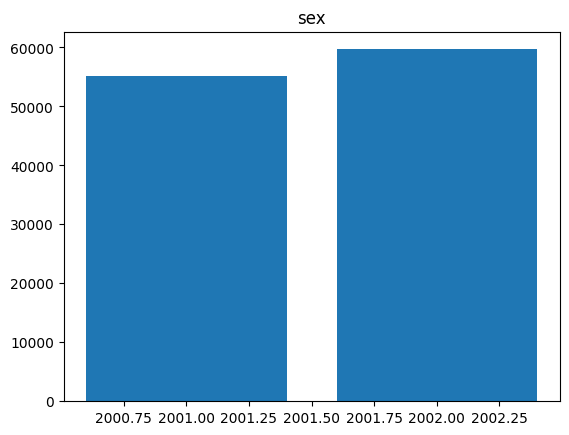

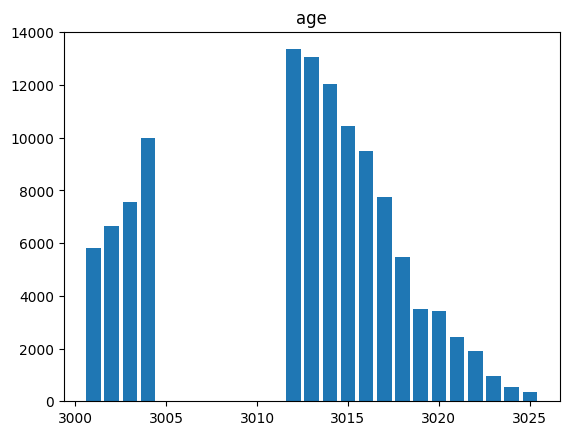

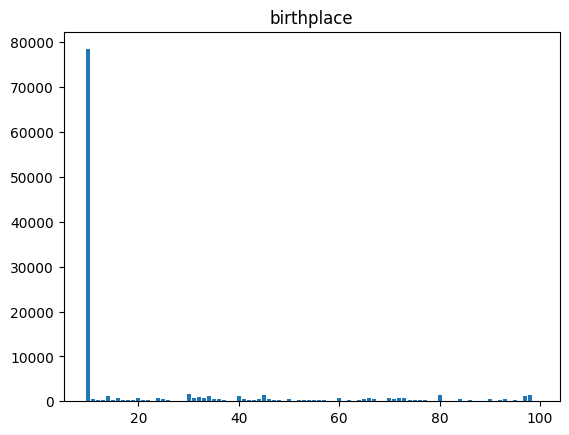

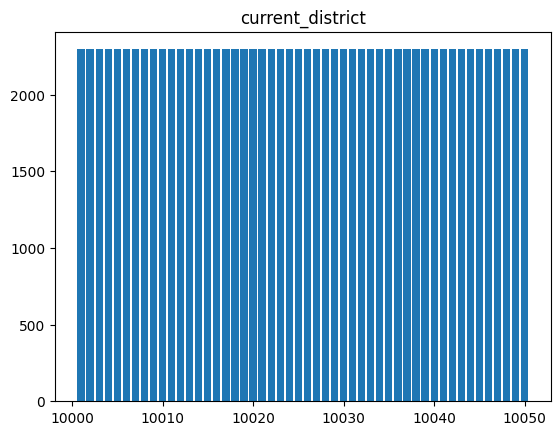

In [ ]:
# plot each attribute's distribution
plot_attribute_distribution(df)

In [ ]:
print_uniq_val(df)

Column name: sex
Unique values: [2001, 2002]
Total unique values: 2


Column name: age
Unique values: [3001, 3002, 3003, 3004, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025]
Total unique values: 18


Column name: birthplace
Unique values: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 76, 77, 80, 81, 82, 83, 84, 85, 86, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Total unique values: 79


Column name: current_district
Unique values: [10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009, 10010, 10011, 10012, 10013, 10014, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10040, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10048,

## Resampling to solve imbalance

In [ ]:
# df['current_district'].value_counts()

In [ ]:
# all_district = []
# for i in list(df['current_district'].unique()):
#     d = df[df['current_district']==i]
#     class_d = d.sample(1500, replace=True)
#     all_district.append(class_d)
# balanced_district = pd.concat(all_district, axis=0)

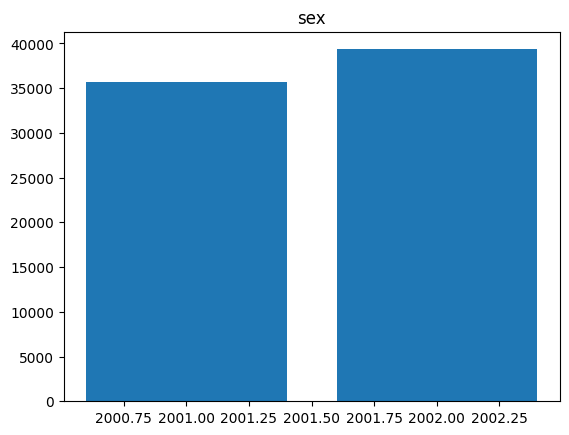

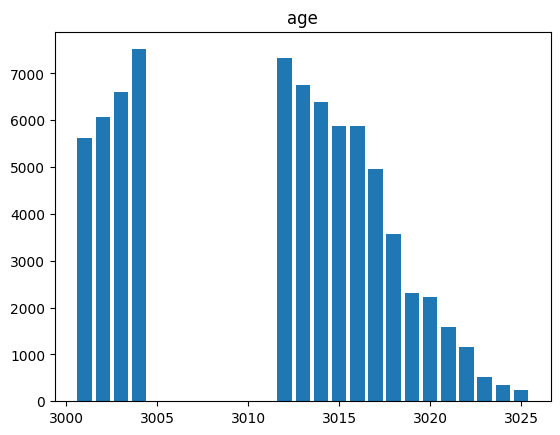

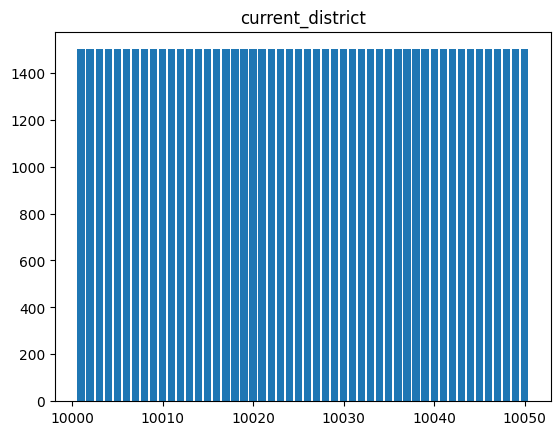

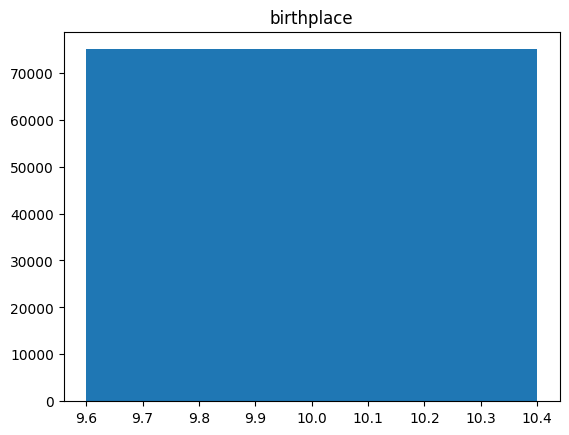

In [ ]:
# plot_attribute_distribution(balanced_district)

In [ ]:
# bp_not_10 = balanced_district[balanced_district['birthplace'] != 10]
# np.mean(bp_not_10['birthplace'].value_counts())

nan

In [ ]:
# bp_10 = balanced_district[balanced_district['birthplace']==10]
# bp_10_under = bp_10.sample(330, replace=False)

In [ ]:
# final = pd.concat([bp_10_under, bp_not_10], axis=0)

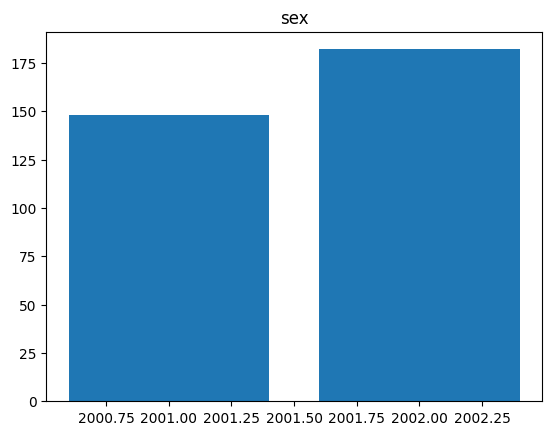

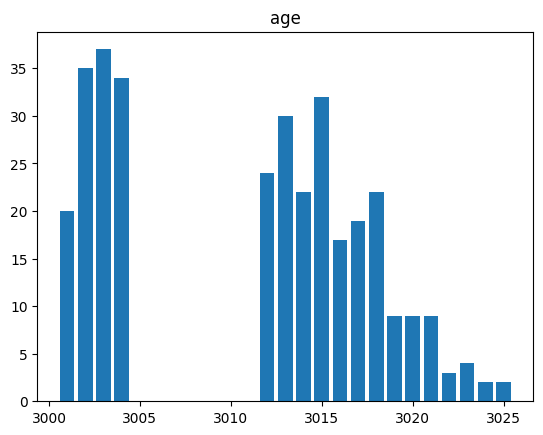

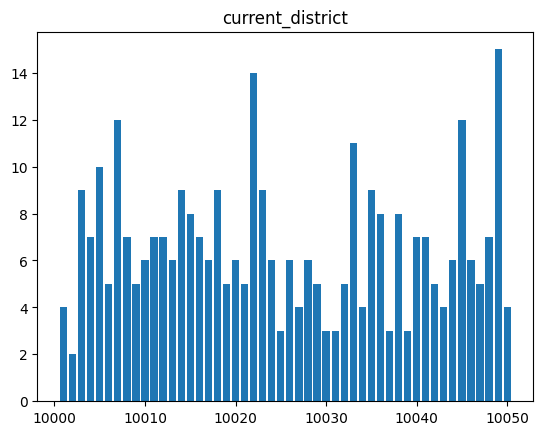

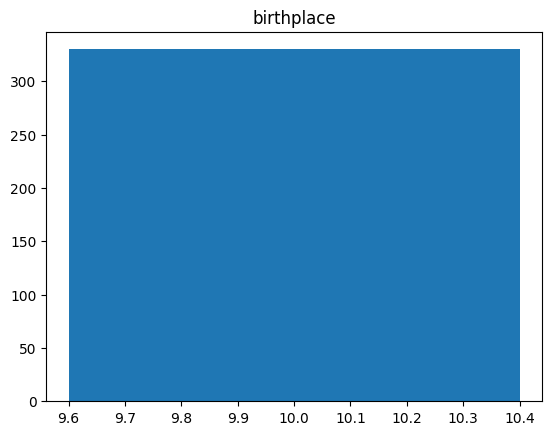

In [ ]:
# plot_attribute_distribution(final)

In [ ]:
# final.to_csv('/content/gdrive/MyDrive/lab/dataset/migration/balanced.csv', index=False, header=True)

## SMOTE-NC

In [ ]:
# df.head()

,sex,age,current_district,birthplace
0,2002,3021,10035,10
1,2001,3004,10035,10
2,2001,3015,10035,10
3,2001,3022,10035,10
4,2002,3015,10035,10


In [ ]:
# # Split data into features and label
# X = df.drop(['current_province'], axis=1)
# y = df['current_province'].values.reshape(-1,1)
# print(f"Orignal dataset shape: X = {X.shape}, y = {y.shape}")

KeyError: ignored

In [ ]:
# X

In [ ]:
# # Define the indices of the categorical features in the dataset
# cat_indices = [2, 3]

# # Define the SMOTENC sampling strategy with the desired parameters
# sampling_strategy = 'auto'  # You can set this to 'minority' or a float value between 0 and 1 to adjust the ratio of the minority class
# smote_nc = SMOTENC(categorical_features=cat_indices, sampling_strategy=sampling_strategy)

# # Apply the SMOTENC sampling to the dataset
# X_resampled, y_resampled = smote_nc.fit_resample(X, y)

# # Print the resampled data to verify that SMOTENC has worked correctly
# print("Original dataset:\n", X, y)
# print("Resampled dataset:\n", X_resampled, y_resampled)

## Split train, validation, test sets

In [ ]:
# df = pd.read_csv('/content/gdrive/MyDrive/lab/dataset/migration/balanced.csv')

In [ ]:
# df.head()

In [ ]:
len(df)

114800

In [ ]:
df = df.sample(100000, replace=True)
df.reset_index(inplace=True)
df = df.drop(['index'], axis=1)

In [ ]:
len(df)

100000

In [ ]:
df.head()

,sex,age,birthplace,current_district
0,2002,3021,10,10035
1,2001,3004,10,10035
2,2001,3015,10,10035
3,2001,3022,10,10035
4,2002,3019,16,10035


In [ ]:
remaining_size = math.floor(0.8*len(df))
test_size = len(df) - remaining_size
train_size = math.floor(0.8*remaining_size)
val_size = remaining_size - train_size
print(f"total: {len(df)}, train: {train_size}, val: {val_size}, test: {test_size}")

total: 114800, train: 73472, val: 18368, test: 22960


In [ ]:
print(test_size + train_size + val_size)

114800


In [ ]:
# randomly select "testing set" from the whole raw dataset
test_df, remaining_df = random_sample(df, n=test_size, random_state=random_state)

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22960 entries, 76380 to 90668
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   sex               22960 non-null  int64
 1   age               22960 non-null  int64
 2   birthplace        22960 non-null  int64
 3   current_district  22960 non-null  int64
dtypes: int64(4)
memory usage: 896.9 KB


In [ ]:
remaining_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91840 entries, 1 to 114799
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   sex               91840 non-null  int64
 1   age               91840 non-null  int64
 2   birthplace        91840 non-null  int64
 3   current_district  91840 non-null  int64
dtypes: int64(4)
memory usage: 3.5 MB


In [ ]:
# Split training and validation sets
train_df, valid_df = random_sample(remaining_df, n=train_size, random_state=random_state)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73472 entries, 66832 to 52405
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   sex               73472 non-null  int64
 1   age               73472 non-null  int64
 2   birthplace        73472 non-null  int64
 3   current_district  73472 non-null  int64
dtypes: int64(4)
memory usage: 2.8 MB


In [ ]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18368 entries, 5 to 114799
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   sex               18368 non-null  int64
 1   age               18368 non-null  int64
 2   birthplace        18368 non-null  int64
 3   current_district  18368 non-null  int64
dtypes: int64(4)
memory usage: 717.5 KB


In [ ]:
print(f'train size: {len(train_df)}')
print(f'validation size: {len(valid_df)}')
print(f'test size: {len(test_df)}')

train size: 73472
validation size: 18368
test size: 22960


In [ ]:
# # Save the testing, training, validation sets as CSV
# test_df.to_csv('/content/gdrive/MyDrive/lab/dataset/migration/test_df.csv',
#                header=True,
#                index=False)

# train_df.to_csv('/content/gdrive/MyDrive/lab/dataset/migration/train_df.csv',
#                     header=True,
#                     index=False)

# valid_df.to_csv('/content/gdrive/MyDrive/lab/dataset/migration/val_df.csv',
#                     header=True,
#                     index=False)

In [ ]:
# get the elements of the dataframe as a list
train_list = train_df.values.flatten().tolist()
valid_list = valid_df.values.flatten().tolist()

# print the resulting list
print("Example of the train list:")
print(train_list[:20])
print("#--------------------#")
print("Example of the valid list:")
print(valid_list[:20])
print("#--------------------#")


train_data = torch.tensor(train_list, dtype=torch.long)
val_data = torch.tensor(valid_list, dtype=torch.long)


# # Split training and validation sets
# remaining_data = torch.tensor(train_list, dtype=torch.long) # alternatively, dtype=torch.long
# n = int(0.9*len(remaining_data)) # first 90% will be train, rest val
# print(f"Size of training set: {n}")
# train_data = remaining_data[:n]
# val_data = remaining_data[n:]

Example of the train list:
[2002, 3021, 70, 10023, 2002, 3017, 73, 10014, 2002, 3013, 10, 10006, 2002, 3012, 36, 10037, 2001, 3016, 10, 10013]
#--------------------#
Example of the valid list:
[2002, 3015, 10, 10035, 2002, 3015, 55, 10035, 2001, 3014, 27, 10035, 2002, 3016, 10, 10035, 2001, 3023, 10, 10035]
#--------------------#


In [ ]:
print(train_data[-10:])
print(train_data[:10])
print(val_data[:10])
print(val_data[-10:])

tensor([   31, 10029,  2001,  3015,    10, 10002,  2001,  3016,    83, 10043])
tensor([ 2002,  3021,    70, 10023,  2002,  3017,    73, 10014,  2002,  3013])
tensor([ 2002,  3015,    10, 10035,  2002,  3015,    55, 10035,  2001,  3014])
tensor([   10, 10050,  2001,  3003,    10, 10050,  2001,  3016,    10, 10050])


## Vocab_size

In [ ]:
# calculate the vocab_size for training model later on
vocab_size, unique_list, max_vocab = count_unique_elements(train_list)
print(f"vocab_size: {vocab_size}")
print(f"unique_list: {unique_list}")
print(f"maximum in vocab: {max_vocab}")

vocab_size: 149
unique_list: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 76, 77, 80, 81, 82, 83, 84, 85, 86, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 2001, 2002, 3001, 3002, 3003, 3004, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009, 10010, 10011, 10012, 10013, 10014, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10040, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10048, 10049, 10050]
maximum in vocab: 10050


# Network Components

## Head

In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

## Multi-head Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

## Feed forward

In [ ]:
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

## Block

In [ ]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

## Bigram Model

In [ ]:
# very simple bigram model
class BigramModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token
        # from a lookup table
        self.token_embedding_table = nn.Embedding(max_vocab+1, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, max_vocab+1)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)

        if debug == True:
            print(f"tok_emb: {tok_emb}")
            
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            if debug == True:
                print(f"logits: {logits}")
                print(f"targets: {targets}")
                print(f"logits shape: {logits.shape}")
                print(f"targets shape: {targets.shape}")
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

# Training Phase

## Train model

In [ ]:
model = BigramModel()
# model.load_state_dict(torch.load(model_path))
m = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

1.695235 M parameters


In [ ]:
train_loss = []
val_loss = []

# get the start time
st = time.time()

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        train_loss.append(losses['train'].numpy())
        val_loss.append(losses['val'].numpy())

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print(f"Training time: {elapsed_time:.2f} seconds")

step 0: train loss 9.3466, val loss 9.3365
step 10: train loss 7.8790, val loss 7.8820
step 20: train loss 6.8255, val loss 6.8273
step 30: train loss 5.7751, val loss 5.7827
step 40: train loss 4.9351, val loss 4.9422
step 50: train loss 4.4473, val loss 4.4297
step 60: train loss 4.1558, val loss 4.1737
step 70: train loss 4.0184, val loss 4.0163
step 80: train loss 3.8897, val loss 3.9075
step 90: train loss 3.7686, val loss 3.7741
step 100: train loss 3.6672, val loss 3.6566
step 110: train loss 3.5720, val loss 3.5758
step 120: train loss 3.4850, val loss 3.4796
step 130: train loss 3.4033, val loss 3.4058
step 140: train loss 3.3224, val loss 3.3365
step 150: train loss 3.2548, val loss 3.2407
step 160: train loss 3.1727, val loss 3.1634
step 170: train loss 3.0822, val loss 3.1131
step 180: train loss 3.0618, val loss 3.0367
step 190: train loss 3.0116, val loss 2.9961
step 200: train loss 2.9624, val loss 2.9693
step 210: train loss 2.9385, val loss 2.9297
step 220: train loss 

In [ ]:
def plot_loss(train_loss, val_loss):
  plt.plot(train_loss, label='train_loss')
  plt.plot(val_loss, label='val_loss')
#   plt.ylim([0, 10])
#   plt.xlim([0,100])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.grid(True)

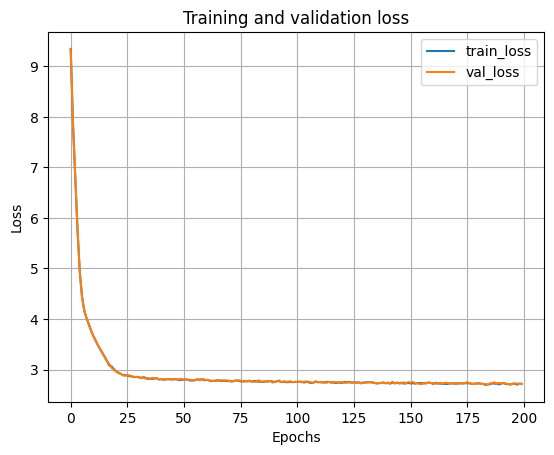

In [ ]:
plot_loss(train_loss, val_loss)

## Save model

In [ ]:
# Save model
torch.save(m.state_dict(), model_path) 

## Load model

In [ ]:
# For generating purpose
vocab_size = 149
max_vocab = 10050

In [ ]:
# Load model
model = BigramModel()
model = model.to(device)
# model.load_state_dict(torch.load(model_path))

# if using CPU only
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


# model.eval()

<All keys matched successfully>

# Generate from the model

## Parallel generation

In [ ]:
print("Number of cpu : ", multiprocessing.cpu_count())

In [ ]:
def generate_data(model, generated_size, block_size, results_queue):
    generated_size = generated_size
    context = torch.zeros((1, 1), dtype=torch.long, device=device)
    r = (block_size*generated_size)-1 # including the zero initial state
    out = model.generate(context, max_new_tokens=r)[0].tolist()

    # ignore the first block as it include the zero initial state
    fin = out[4:]
    
    # return out
    results_queue.put(fin) # for multiprocessing Queue


In [ ]:
if __name__ == '__main__':
    # Create a multiprocessing Queue object to hold the results
    results_queue = Queue()
    
    # Create two process objects and pass arguments to my_func
    p1 = Process(target=generate_data, args=(model, 1000+1, 4, results_queue))
    p2 = Process(target=generate_data, args=(model, 1000+1, 4, results_queue))
    p3 = Process(target=generate_data, args=(model, 1000+1, 4, results_queue))
    p4 = Process(target=generate_data, args=(model, 1000+1, 4, results_queue))
    
    # Start the timer
    start_time = time.time()

    # Start the processes
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    
    # Wait for the processes to finish
    p1.join()
    p2.join()
    p3.join()
    p4.join()
    
    # Get the results from the Queue
    results = []
    while not results_queue.empty():
        results.append(results_queue.get())
    print(f"Results: {results}")

    # Calculate the time taken
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total time taken: {total_time} seconds")

In [ ]:
type(results)

In [ ]:
len(results)

In [ ]:
len(results[0])

In [ ]:
print(results[0][:12])
print(results[1][:12])
print(results[2][:12])
print(results[3][:12])

In [ ]:
print(results[0][-12:])
print(results[1][-12:])
print(results[2][-12:])
print(results[3][-12:])

In [ ]:
# gen = []
gen.append(flatten_list(results))

In [ ]:
print(gen)
print(len(gen))

In [ ]:
gen_list = flatten_list(gen)

In [ ]:
print(len(gen_list))

In [ ]:
print(gen_list)

## Sequentially generate the data

In [ ]:
def generate_data_sequentially(size, block_size, initialized_token=0, filename=1):
    context = torch.tensor(([[initialized_token]]), dtype=torch.long, device=device)
    r = (block_size * size)
    output = model.generate(context, max_new_tokens=r)[0].tolist()
    output_path = f"/content/gdrive/MyDrive/lab/Transformer/MGM5/{filename}.csv"
    print(output_path)
    np.savetxt(output_path, output, delimiter = ',', fmt='%i')
    # output.save(f"/content/gdrive/MyDrive/lab/Transformer/{filename}.csv")
    print(f"file: {filename}, generated output length: {len(output)}")
    # return output

In [ ]:
%%time
generate_data_sequentially(100000,4,33,15)

/content/gdrive/MyDrive/lab/Transformer/MGM5/15.csv
file: 15, generated output length: 400001
CPU times: user 2h 57min 41s, sys: 29.4 s, total: 2h 58min 11s
Wall time: 2h 59min 34s


In [ ]:
# %%time

# thr1 = threading.Thread(target=generate_data_sequentially, args=[500,4,0,1])
# thr2 = threading.Thread(target=generate_data_sequentially, args=[500,4,10,2])

# thr1.start()
# thr2.start()

# thr1.join()
# thr2.join()

In [ ]:
total_people = 5550000
(total_people*(2/60))/1000

185.0

In [ ]:
185/24

7.708333333333333

In [ ]:
# generated_size = 3594000 #3593200

# # generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# r = (block_size*generated_size)
# # r = 62000

# out = model.generate(context, max_new_tokens=r)[0].tolist()

# print(f"Generated tokens: {len(out)} tokens")

## Save the generated tokens

In [ ]:
# save the generated tokens using "savetxt" from the numpy module
np.savetxt('/content/gdrive/MyDrive/lab/Transformer/MGM7_bkk_bkk_2564_tokens.csv', 
           out,
           delimiter = ',',
           fmt='%i')

In [ ]:
# load the saved tokens using numpy
gen_result = np.loadtxt('/content/gdrive/MyDrive/lab/Transformer/MGM7_bkk_bkk_2564_tokens.csv',
                        delimiter = ',',
                        dtype='i4')

# convert the loaded result to list
gen_result = list(gen_result)
print(len(gen_result))

62001


In [ ]:
print(gen_result[:20])
print(gen_result[-20:])

[0, 20, 2002, 3014, 10034, 71, 2002, 3003, 10020, 14, 2002, 3012, 10037, 90, 2001, 3013, 10014, 14, 2002, 3014]
[3014, 10020, 84, 2002, 3012, 10034, 44, 2001, 3016, 10019, 14, 2002, 3013, 10026, 16, 2001, 3012, 10027, 81, 2002]


In [ ]:
# Remove irrelevant tokens
gen_result = gen_result[2:] # remove first few tokens

In [ ]:
print(gen_result[:12])
print(gen_result[-12:])

[2002, 3014, 10034, 71, 2002, 3003, 10020, 14, 2002, 3012, 10037, 90]
[3016, 10019, 14, 2002, 3013, 10026, 16, 2001, 3012, 10027, 81, 2002]


In [ ]:
gen_result = gen_result[:-1] # remove last few tokens

In [ ]:
print(gen_result[:12])
print(gen_result[-12:])

[2002, 3014, 10034, 71, 2002, 3003, 10020, 14, 2002, 3012, 10037, 90]
[2001, 3016, 10019, 14, 2002, 3013, 10026, 16, 2001, 3012, 10027, 81]


# Validate the generated data

In [ ]:
birthplace_set = list(df['birthplace'].unique())
district_set = list(df['current_district'].unique())
sex_set = list(df['sex'].unique())
age_set = list(df['age'].unique())

In [ ]:
checking_lst = gen_result
print(f'len checking_lst: {len(checking_lst)}')

len checking_lst: 61998


In [ ]:
### The order of attributes is BIRTHPLACE, DISTRICT, PREV_PROV


# get the start time
st = time.time()


all_ex = []
ex = []
lex = len(ex)

while (len(checking_lst) > 0) and (lex < block_size):
    item = checking_lst.pop(0)
    if(lex == 0) and (item in sex_set):
        ex.append(item)
    elif(lex == 1) and (item in age_set):
        ex.append(item)
    elif(lex == 2) and (item in district_set):
        ex.append(item)
    elif(lex == 3) and (item in birthplace_set):
        ex.append(item)
    # elif(lex == 2) and (len(str(item)) == 6):
    #     ex.append(item)

    lex = len(ex)

    if lex == block_size:
        all_ex.append(ex)
        ex = []
    lex = len(ex)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print(f"Validation time: {elapsed_time:.2f} seconds")

Validation time: 0.44 seconds


In [ ]:
all_ex

[[2002, 3014, 10034, 71],
 [2002, 3003, 10020, 14],
 [2002, 3012, 10037, 90],
 [2001, 3013, 10014, 14],
 [2002, 3014, 10037, 54],
 [2001, 3014, 10020, 14],
 [2001, 3012, 10027, 45],
 [2002, 3023, 10034, 75],
 [2001, 3015, 10022, 86],
 [2001, 3020, 10050, 66],
 [2002, 3014, 10036, 45],
 [2002, 3014, 10012, 53],
 [2002, 3013, 10030, 71],
 [2001, 3021, 10026, 56],
 [2002, 3012, 10026, 32],
 [2002, 3012, 10016, 32],
 [2002, 3012, 10037, 93],
 [2001, 3014, 10007, 35],
 [2002, 3023, 10027, 30],
 [2002, 3004, 10021, 80],
 [2002, 3014, 10022, 33],
 [2002, 3012, 10048, 45],
 [2002, 3013, 10038, 64],
 [2002, 3023, 10027, 47],
 [2002, 3015, 10029, 73],
 [2002, 3014, 10027, 30],
 [2002, 3012, 10024, 26],
 [2001, 3012, 10003, 31],
 [2001, 3019, 10030, 44],
 [2001, 3014, 10028, 98],
 [2001, 3014, 10046, 50],
 [2001, 3020, 10009, 72],
 [2001, 3003, 10037, 43],
 [2002, 3017, 10040, 30],
 [2002, 3014, 10041, 30],
 [2002, 3016, 10014, 44],
 [2001, 3012, 10047, 26],
 [2002, 3017, 10035, 98],
 [2001, 3012

In [ ]:
print(f"Total tokens after position validation: {len(all_ex)*block_size}")
print(f"Total generated examples: {len(all_ex)}")

Total tokens after position validation: 61296
Total generated examples: 15324


In [ ]:
# create a DF of checked examples
syn_df = pd.DataFrame(all_ex, columns = ['sex', 'age', 'current_district', 'birthplace'])
 
# print dataframe.
print(syn_df)

        sex   age  current_district  birthplace
0      2002  3014             10034          71
1      2002  3003             10020          14
2      2002  3012             10037          90
3      2001  3013             10014          14
4      2002  3014             10037          54
...     ...   ...               ...         ...
15319  2002  3014             10020          84
15320  2002  3012             10034          44
15321  2001  3016             10019          14
15322  2002  3013             10026          16
15323  2001  3012             10027          81

[15324 rows x 4 columns]


In [ ]:
syn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15324 entries, 0 to 15323
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   sex               15324 non-null  int32
 1   age               15324 non-null  int32
 2   current_district  15324 non-null  int32
 3   birthplace        15324 non-null  int32
dtypes: int32(4)
memory usage: 239.6 KB


In [ ]:
print_uniq_val(syn_df)

Column name: sex
Unique values: [2001, 2002]
Total unique values: 2


Column name: age
Unique values: [3001, 3002, 3003, 3004, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025]
Total unique values: 18


Column name: current_district
Unique values: [10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009, 10010, 10011, 10012, 10013, 10014, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10040, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10048, 10049, 10050]
Total unique values: 50


Column name: birthplace
Unique values: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 76, 77, 80, 81, 82, 83, 84, 85, 86, 90, 91, 92, 93, 94, 95, 96, 9

In [ ]:
# Save synthetic DF as CSV for evaluation
syn_df.to_csv('/content/gdrive/MyDrive/lab/Transformer/MGM7_bkk_other_syn_df.csv',
          header=True,
          index=False)

# Visualize the results

In [ ]:
syn_df = syn_df.sample(n=test_size, replace=True, random_state=random_state)
syn_df.reset_index(inplace=True, drop=True)

In [ ]:
syn_df.head()

,sex,age,current_district,birthplace
0,2001,3013,10037,62
1,2001,3014,10003,21
2,2001,3004,10010,33
3,2001,3013,10003,40
4,2001,3017,10045,98


In [ ]:
len(test_df) == len(syn_df)

True

In [ ]:
def validate_attr(df_real, df_syn, columns_to_plot=None, legend_labels=None, title=None, unique_values=None, labelrotation=None):
    if columns_to_plot is None:
        columns_to_plot = df_real.columns
    
    # Iterate over each column in the dataframes
    for i, col in enumerate(columns_to_plot):
        # Create a new figure and axis object for each attribute
        fig, ax = plt.subplots()

        # Get the frequencies for each unique value in the column
        freq1 = df_real[col].value_counts()
        freq2 = df_syn[col].value_counts()

        # Combine the frequencies into a single dataframe
        freq_df = pd.concat([freq1, freq2], axis=1, keys=['real', 'synthetic'])

        if unique_values is not None:
            # Sort the unique values in the column based on their order of appearance
            unique_values = unique_values
            # Plot the frequencies as a bar chart with sorted unique values
            freq_df.loc[unique_values].plot(kind='bar', ax=ax, rot=0)
        else:
            # Plot the frequencies as a bar chart
            freq_df.plot(kind='bar', ax=ax, rot=0)

        if title is not None:
            # Set the title for the subplot
            ax.set_title(title)
        else:
            ax.set_title(col)
        
        # ax.set_ylabel('Frequency')
        # ax.set_xlabel('Category')
        ax.set(xlabel='Category', ylabel='Frequency')
        ax.tick_params('x', labelrotation=labelrotation)

        # # Add a legend to the plot
        # plt.legend(legend_labels)
        # plt.legend(bbox_to_anchor=(1.0, 1.0), loc='center')

        # # Hide the legend
        # ax.legend().remove()

        # Check if legend_labels is not None and has at least one element
        if legend_labels and len(legend_labels) > 0:
            # Add a legend to the plot
            plt.legend(legend_labels)
            # plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        else:
            # Hide the legend
            ax.legend().remove()

        # Show the plot
        plt.show()


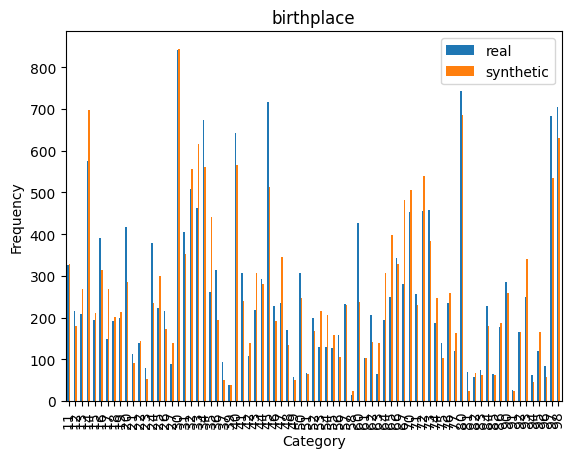

In [ ]:
validate_attr(
    df_real=test_df,
    df_syn=syn_df,
    columns_to_plot=['birthplace'],
    # title='Age Group',
    unique_values=np.sort(test_df['birthplace'].unique()),
    legend_labels=['real', 'synthetic'],
    labelrotation=90,
)